# Package Imports
All the packages below are what will be needed to train a variety of models

In [1]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import precision_score as prec
from sklearn.metrics import recall_score as rec
from sklearn.metrics import f1_score as f1
from sklearn.preprocessing import LabelEncoder
import numpy as np
import seaborn as sns
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import export_graphviz
from IPython.display import Image
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Create Helper Functions
The methods below help to streamline the process of model creation and evaluation

In [2]:
def update(d, key, value):
    if key not in d:
        raise KeyError(f"Key '{key}' not found")
        
    d[key] = value
    return d

In [3]:
def model_dict(model_names: list):
    models = {}
    
    for name in model_names:
        models[name] = {
            "model": None,
            "metrics": None
        }
        
    return models

In [4]:
# Full model evaluation
def evaluate_model(model, testing_data, testing_label): 
    evals = {}
    y_pred = model.predict(testing_data)
    
    evals["accuracy"] = np.round(acc(testing_label, y_pred), 3)
    evals["precision"] = np.round(prec(testing_label, y_pred), 3)
    evals["recall"] = np.round(rec(testing_label, y_pred), 3)
    evals["f1"] = np.round(f1(testing_label, y_pred), 3)

    return evals, y_pred

In [5]:
def monte_carlo_cv(model, data_in, labels_in, n_iterations=500, check_overfitting=False, train_size=0.8):
    
    metrics = {
        "y_true": [],
        "y_pred": [],
        "training": {
            "accuracy": {
                "raw": []
            },
            "precision": {
                "raw": []
            },
            "recall": {
                "raw": []
            },
            "f1": {
                "raw": []
            }
        },
        "testing": {
            "accuracy": {
                "raw": []
            },
            "precision": {
                "raw": []
            },
            "recall": {
                "raw": []
            },
            "f1": {
                "raw": []
            }
        }
    }
    
    for i in range(n_iterations):
        if i % 10 == 0:
            print(f"Progress: iteration {i}")
        x_train, x_test, y_train, y_test = train_test_split(data_in, labels_in, train_size=train_size)        
        model.fit(x_train, y_train)
        evals, y_pred = evaluate_model(model, x_test, y_test)
        
        metrics["y_true"].append(y_test)
        metrics["y_pred"].append(y_pred)
        
        for key in evals.keys():
            metrics["testing"][key]["raw"].append(evals[key])
            
        if check_overfitting:
            evals, y_pred = evaluate_model(model, x_train, y_train)
            for key in evals.keys():
                metrics["training"][key]["raw"].append(evals[key])
            
    for data_type in metrics.keys():
        
        if not check_overfitting and data_type == "training":
            continue
            
        if data_type == "y_pred" or data_type == "y_true":
            continue
        
        for key in metrics[data_type].keys():
            metrics[data_type][key]["raw"] = np.array(metrics[data_type][key]["raw"])
            metrics[data_type][key]["mean"] = np.mean(metrics[data_type][key]["raw"])
            metrics[data_type][key]["std"] = np.std(metrics[data_type][key]["raw"])
        
    return metrics, n_iterations

In [6]:
def plot_metric_histograms(model_name, metrics_dict, n_iterations, metrics_data="testing"):
    
    mod_mean = 0
    mod_std = 1
    
    for key in metrics_dict[metrics_data].keys():
        if key == "y_pred":
            continue
        mod_mean = np.round(metrics_dict[metrics_data][key]["mean"], 3)
        mod_std = np.round(metrics_dict[metrics_data][key]["std"], 3)
        plt.figure()
        plt.title(f"{model_name} {key} over {n_iterations} iterations.\nμ = {mod_mean}, σ = {mod_std}")
        sns.histplot(metrics_dict[metrics_data][key]["raw"])
        plt.plot()
        
    return mod_mean, mod_std

In [7]:
def visualize_overfitting(accuracy_dict, xlab, ylab, plot_title):
    
    ind_var = accuracy_dict["var"]
    training = accuracy_dict["training"]
    testing = accuracy_dict["testing"]
        
    plt.title(plot_title)
    plt.plot(accuracy_dict["var"], accuracy_dict["training"], label="training data")
    plt.plot(accuracy_dict["var"], accuracy_dict["testing"], label="testing data")
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    
    try:
        five_p = ind_var[np.where(np.array(testing) + 0.05 < np.array(training))[0][0]]
        plt.axvline(x=five_p, label=">5% difference", color="red", linestyle='--')
    except IndexError:
        pass
    
    plt.legend()
    plt.show()

In [8]:
def get_middle_y_arrays(metrics_dict, score="accuracy"):
    n = len(metrics_dict["testing"][score]["raw"])
    sorted_idxs = metrics_dict["testing"][score]["raw"].argsort()
    mid_idx = sorted_idxs[n//2]
    print()
    
    return metrics_dict["y_true"][mid_idx], metrics_dict["y_pred"][mid_idx]

In [9]:
def create_confusion_matrix(y_true, y_pred, label0, label1, title):
    conf_mat = confusion_matrix(y_true, y_pred)
    mat_disp = ConfusionMatrixDisplay(conf_mat, display_labels = [label0, label1]).plot()
    mat_disp.ax_.set_title(title)
    plt.show()

In [10]:
def get_acc_diff_at_point(accuracy_dict, ind_var_point):
    idx = np.where(accuracy_dict["var"] == ind_var_point)
    return accuracy_dict["training"][idx] - accuracy_dict["testing"][idx]

In [11]:
# Code source for visualization
# https://towardsdatascience.com/how-to-visualize-a-decision-tree-from-a-random-forest-in-python-using-scikit-learn-38ad2d75f21c/

def decision_tree_viz(model, feature_names_, out_file_name):
    # Export as dot file
    export_graphviz(model, out_file='tree.dot', 
                    feature_names = feature_names_,
                    rounded = True, proportion = False, 
                    precision = 2, filled = True,
                   max_depth=5)

    # Convert to png using system command (requires Graphviz)
    out_file_path = os.path.join("desc-trees", out_file_name)
    from subprocess import call
    call(['dot', '-Tjpg', 'tree.dot', '-o', out_file_path, '-Gdpi=300'])

In [12]:
def create_manual_metrics(manual_mets, model_name, accuracy, precision, recall, f1):
    mets_dict = {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }
    
    manual_mets[model_name] = mets_dict
    
    return manual_mets

# Read in data

In [13]:
path_to_data = "../text-mining-project-data/clean"
lg_count = os.path.join(path_to_data, "count-4856.csv")
md_count = os.path.join(path_to_data, "count-500.csv")
sm_count = os.path.join(path_to_data, "stem-count-100.csv")

In [14]:
lg_df = pd.read_csv(lg_count)
md_df = pd.read_csv(md_count)
sm_df = pd.read_csv(sm_count)

In [15]:
enc = LabelEncoder()
enc.fit_transform(["left", "right"])

array([0, 1])

In [16]:
dfs = {
    "lg": {
        "data": lg_df.copy().drop("labels", axis=1),
        "labels": enc.transform(lg_df["labels"])
    },
    "md": {
        "data": md_df.copy().drop("labels", axis=1),
        "labels": enc.transform(md_df["labels"])
    },
    "sm": {
        "data": sm_df.copy().drop("labels", axis=1),
        "labels": enc.transform(sm_df["labels"])
    }
}

# Create Models

In [17]:
models = model_dict(["Multinomial NB",
                    "Decision Tree",
                    "SVM - RBF",
                    "SVM - POLY",
                    "SVM - LINEAR"])
models

{'Multinomial NB': {'model': None, 'metrics': None},
 'Decision Tree': {'model': None, 'metrics': None},
 'SVM - RBF': {'model': None, 'metrics': None},
 'SVM - POLY': {'model': None, 'metrics': None},
 'SVM - LINEAR': {'model': None, 'metrics': None}}

# Example of data partitions

In [18]:
print("Full data shape:", lg_df.shape)
print("Sample of data:")
lg_df.sample(10)

Full data shape: (2625, 4855)
Sample of data:


labels  aaron  abandoned  abbott  abc  abiding  ability  able  abortion  \
2386   left      0          0       0    0        0        0     1         0   
751   right      0          0       0    0        0        0     0         0   
1495  right      0          0       0    0        0        0     0         0   
1465  right      0          0       0    0        0        0     0         0   
436   right      0          0       0    0        0        0     0         0   
653   right      0          0       0    0        0        0     0         0   
2576   left      0          0       3    0        0        0     0         0   
1228   left      0          0       0    0        0        0     0         0   
2607   left      0          0       0    0        0        0     0         0   
1562  right      0          0       0    0        0        0     0         0   

      abroad  ...  younger  youngest  youre  youth  youtube  youve  zealand  \
2386       0  ...        0         0      0      0        1      0        1   
751        0  ...        0         0      0      0        0      0        0   
1495       0  ...        0         0      0      0        0      0        0   
1465       0  ...        0         0      0      0        0      0        0   
436        0  ...        0         0      0      0        0      0        0   
653        0  ...        0         0      0      0        0      0        0   
2576       0  ...        0         0      0      0        0      0        0   
1228       0  ...        0         0      1      0        0      0        0   
2607       0  ...        0         0      0      0        0      0        0   
1562       0  ...        0         0      0      0        1      0        0   

      zero  zone  zones  
2386     0     0      0  
751      0     0      0  
1495     0     0      0  
1465     0     0      0  
436      0     0      0  
653      0     0      0  
2576     0     0      0  
1228     0     0      0  
2607     0     0      0  
1562     0     0      0  

[10 rows x 4855 columns]

In [19]:
# Example of train-test split
x_train, x_test, y_train, y_test = train_test_split(dfs["lg"]["data"], dfs["lg"]["labels"], train_size=0.9)

In [20]:
x_train

aaron  abandoned  abbott  abc  abiding  ability  able  abortion  abroad  \
1313      0          0       0    0        0        0     0         0       0   
1242      0          0       0    0        0        0     0         0       0   
2509      0          0       0    0        0        0     0         0       0   
747       0          0       0    0        0        0     0         0       0   
2468      0          0       0    0        0        0     0         0       0   
...     ...        ...     ...  ...      ...      ...   ...       ...     ...   
1498      0          0       0    0        0        0     0         0       0   
2329      0          0       0    0        0        0     0         0       0   
2328      0          0       0    0        0        0     0         0       0   
1433      0          0       0    0        0        0     0         0       0   
2484      0          0       0    0        0        0     0         0       0   

      absence  ...  younger  youngest  youre  youth  youtube  youve  zealand  \
1313        0  ...        0         0      0      0        0      0        0   
1242        0  ...        0         0      0      0        0      0        0   
2509        0  ...        0         0      1      0        0      0        0   
747         0  ...        0         0      0      0        0      0        0   
2468        0  ...        0         0      0      0        0      0        0   
...       ...  ...      ...       ...    ...    ...      ...    ...      ...   
1498        0  ...        0         0      0      0        0      0        0   
2329        0  ...        0         0      0      0        2      0        0   
2328        0  ...        0         0      0      0        0      0        0   
1433        0  ...        0         0      0      0        0      0        0   
2484        0  ...        0         0      0      0        0      0        0   

      zero  zone  zones  
1313     0     2      0  
1242     0     0      0  
2509     1     0      0  
747      0     0      0  
2468     0     0      0  
...    ...   ...    ...  
1498     0     0      0  
2329     0     0      0  
2328     0     0      0  
1433     0     0      0  
2484     0     0      0  

[2362 rows x 4854 columns]

In [21]:
x_test

aaron  abandoned  abbott  abc  abiding  ability  able  abortion  abroad  \
1937      0          0       0    0        0        0     1        64       0   
2073      0          0       0    0        0        1     1         0       0   
1707      0          0       0    0        0        0     0         0       0   
622       0          0       0    0        0        0     0         0       0   
2384      0          0       0    0        0        0     1         0       0   
...     ...        ...     ...  ...      ...      ...   ...       ...     ...   
791       0          0       0    0        1        0     0         0       0   
1062      0          0       0    0        0        0     0         0       0   
872       0          0       0    0        0        0     0         0       0   
1342      0          0       0    0        0        0     0         0       0   
1439      0          0       0    0        0        0     0         0       1   

      absence  ...  younger  youngest  youre  youth  youtube  youve  zealand  \
1937        0  ...        2         0      0      0        0      1        0   
2073        0  ...        0         0      0      0        0      0        0   
1707        0  ...        0         0      0      0        0      0        0   
622         0  ...        0         0      0      0        0      0        0   
2384        0  ...        0         0      0      0        0      0        0   
...       ...  ...      ...       ...    ...    ...      ...    ...      ...   
791         0  ...        0         0      0      0        0      0        0   
1062        0  ...        0         0      0      0        0      0        0   
872         0  ...        0         0      0      0        0      0        0   
1342        0  ...        0         0      0      0        0      0        0   
1439        0  ...        0         0      0      0        0      0        0   

      zero  zone  zones  
1937     0     0      0  
2073     0     0      0  
1707     0     0      0  
622      0     0      0  
2384     0     0      0  
...    ...   ...    ...  
791      0     0      0  
1062     0     0      0  
872      0     0      0  
1342     0     0      0  
1439     0     0      0  

[263 rows x 4854 columns]

In [22]:
pd.DataFrame(y_train, columns=["labels"])

labels
0          0
1          0
2          0
3          1
4          0
...      ...
2357       1
2358       0
2359       0
2360       1
2361       0

[2362 rows x 1 columns]

In [23]:
pd.DataFrame(y_test, columns=["labels"])

labels
0         0
1         0
2         0
3         1
4         0
..      ...
258       1
259       0
260       1
261       0
262       1

[263 rows x 1 columns]

# Naive Bayes

### Overfitting?
Below, we check for overfitting through looking at training accuracy vs testing accuracy

In [52]:
accuracies_dict = {
    "var": [],
    "training": [],
    "testing": []
}

alpha = np.arange(0.1, 2.1, 0.1)
for _, val in enumerate(alpha):
    print(f"Running with alpha={val}")
    nb = MultinomialNB(alpha = val)
    metrics, iters = monte_carlo_cv(nb, 
                                    dfs["lg"]["data"], dfs["lg"]["labels"], 
                                    n_iterations=40, 
                                    check_overfitting=True,
                                    train_size=0.9)

    accuracies_dict["var"].append(val)
    accuracies_dict["training"].append(metrics["training"]["accuracy"]["mean"])
    accuracies_dict["testing"].append(metrics["testing"]["accuracy"]["mean"])
    
for key in accuracies_dict.keys():
    accuracies_dict[key] = np.array(accuracies_dict[key])

Running with alpha=0.1
Progress: iteration 0
Progress: iteration 10
Progress: iteration 20
Progress: iteration 30
Running with alpha=0.2
Progress: iteration 0
Progress: iteration 10
Progress: iteration 20
Progress: iteration 30
Running with alpha=0.30000000000000004
Progress: iteration 0
Progress: iteration 10
Progress: iteration 20
Progress: iteration 30
Running with alpha=0.4
Progress: iteration 0
Progress: iteration 10
Progress: iteration 20
Progress: iteration 30
Running with alpha=0.5
Progress: iteration 0
Progress: iteration 10
Progress: iteration 20
Progress: iteration 30
Running with alpha=0.6
Progress: iteration 0
Progress: iteration 10
Progress: iteration 20
Progress: iteration 30
Running with alpha=0.7000000000000001
Progress: iteration 0
Progress: iteration 10
Progress: iteration 20
Progress: iteration 30
Running with alpha=0.8
Progress: iteration 0
Progress: iteration 10
Progress: iteration 20
Progress: iteration 30
Running with alpha=0.9
Progress: iteration 0
Progress: it

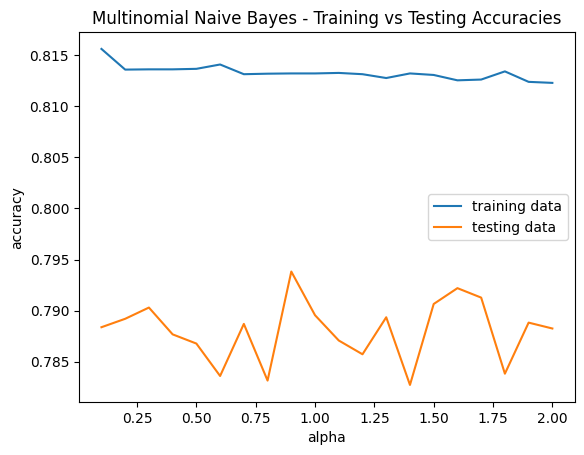

In [56]:
# No overfitting! The gap between is small
visualize_overfitting(accuracies_dict, "alpha", "accuracy", "Multinomial Naive Bayes - Training vs Testing Accuracies")

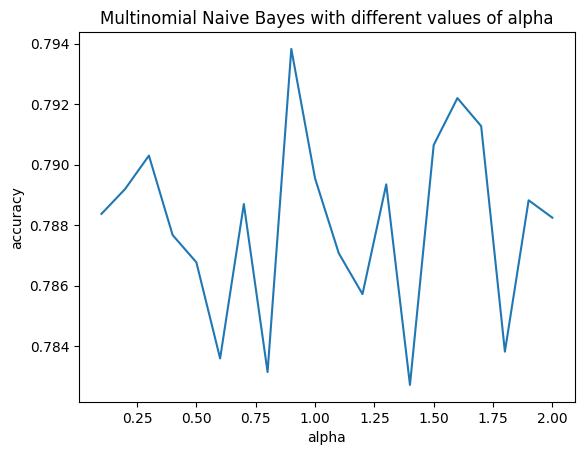

In [54]:
# Based on this plot and potential error with random initialization and sampling, we'll use the default alpha: 1
plt.title("Multinomial Naive Bayes with different values of alpha")
plt.xlabel("alpha")
plt.ylabel("accuracy")
plt.plot(accuracies_dict["var"], accuracies_dict["testing"])

In [68]:
nb = MultinomialNB()
nb.fit(dfs["lg"]["data"], dfs["lg"]["labels"])

MultinomialNB()

In [79]:
left = nb.feature_log_prob_[0]
right = nb.feature_log_prob_[1]
top_5_left = left.argsort()[::-1][:20]
top_5_right = right.argsort()[::-1][:20]

In [80]:
np.exp(left[top_5_left])

array([0.00791973, 0.00506417, 0.00449698, 0.00392376, 0.00381844,
       0.00376729, 0.00360631, 0.00342125, 0.00325124, 0.00317451,
       0.00307822, 0.0028029 , 0.00263289, 0.00259829, 0.0023681 ,
       0.0023681 , 0.00233951, 0.00232898, 0.00226128, 0.00224172])

In [81]:
dfs["lg"]["data"].columns[top_5_left]

Index(['gun', 'police', 'year', 'school', 'trump', 'just', 'state', 'violence',
       'years', 'time', 'law', 'black', 'white', 'states', 'president',
       'public', 'shootings', 'day', 'dont', 'right'],
      dtype='object')

In [82]:
np.exp(right[top_5_right])

array([0.01143526, 0.00709535, 0.00623781, 0.00604628, 0.00586346,
       0.00464462, 0.00457062, 0.00427027, 0.00418321, 0.00320814,
       0.00295567, 0.00289908, 0.00286426, 0.0028512 , 0.00273367,
       0.0026379 , 0.00258567, 0.00257261, 0.0025639 , 0.00254214])

In [83]:
dfs["lg"]["data"].columns[top_5_right]

Index(['police', 'school', 'year', 'killed', 'gun', 'victims', 'old', 'just',
       'shot', 'time', 'shooter', 'law', 'state', 'gunman', 'shootings',
       'family', 'authorities', 'man', 'texas', 'city'],
      dtype='object')

In [84]:
nb = MultinomialNB()
metrics, iters = monte_carlo_cv(nb, dfs["lg"]["data"], dfs["lg"]["labels"])

Progress: iteration 0
Progress: iteration 10
Progress: iteration 20
Progress: iteration 30
Progress: iteration 40
Progress: iteration 50
Progress: iteration 60
Progress: iteration 70
Progress: iteration 80
Progress: iteration 90
Progress: iteration 100
Progress: iteration 110
Progress: iteration 120
Progress: iteration 130
Progress: iteration 140
Progress: iteration 150
Progress: iteration 160
Progress: iteration 170
Progress: iteration 180
Progress: iteration 190
Progress: iteration 200
Progress: iteration 210
Progress: iteration 220
Progress: iteration 230
Progress: iteration 240
Progress: iteration 250
Progress: iteration 260
Progress: iteration 270
Progress: iteration 280
Progress: iteration 290
Progress: iteration 300
Progress: iteration 310
Progress: iteration 320
Progress: iteration 330
Progress: iteration 340
Progress: iteration 350
Progress: iteration 360
Progress: iteration 370
Progress: iteration 380
Progress: iteration 390
Progress: iteration 400
Progress: iteration 410
Pro

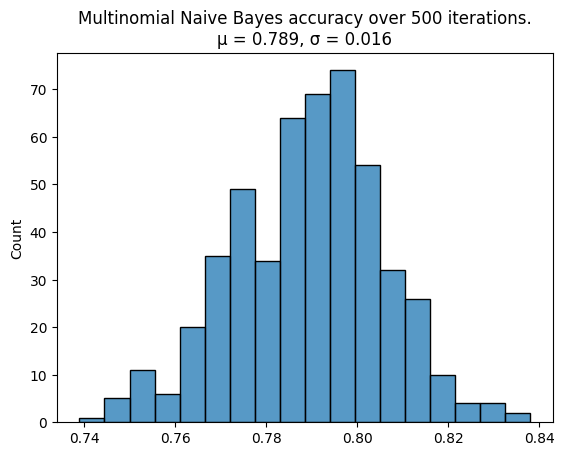

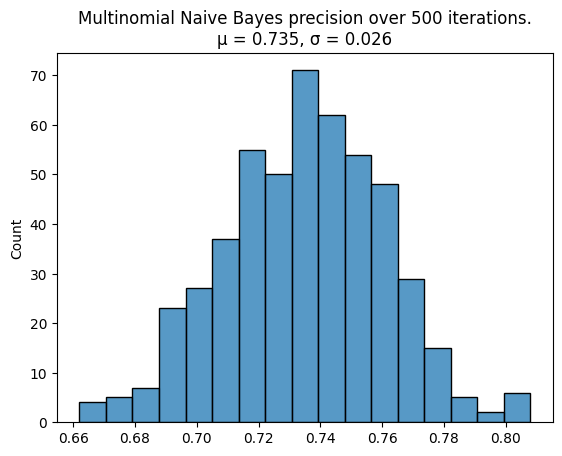

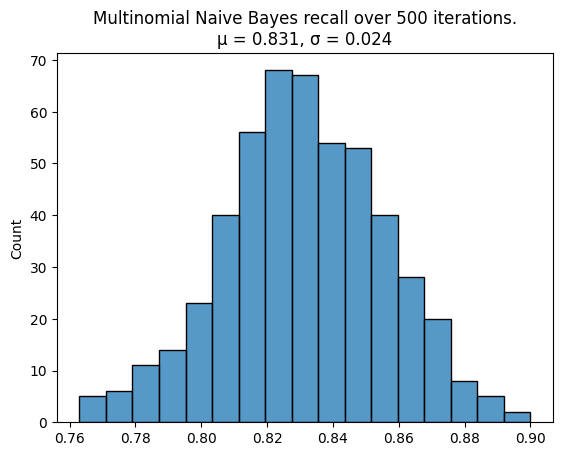

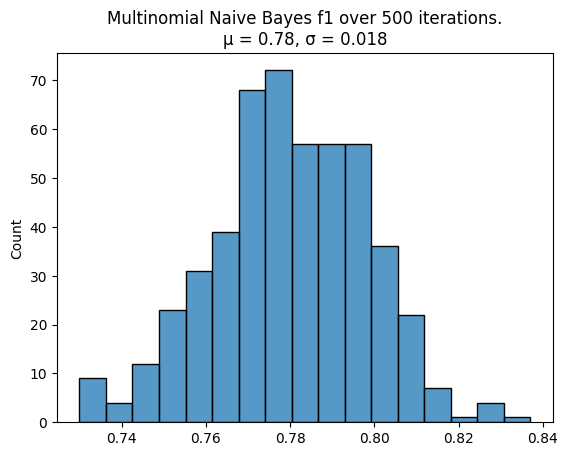

In [224]:
nb_dict = {
    "model": nb,
    "metrics": metrics
}

models = update(models, "Multinomial NB", nb_dict)
nb_mean, nb_std = plot_metric_histograms("Multinomial Naive Bayes", metrics, iters)

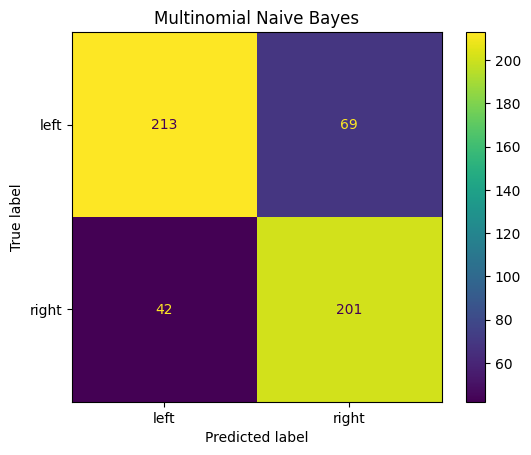

In [225]:
y_true, y_pred = get_middle_y_arrays(metrics)
create_confusion_matrix(y_true, y_pred, "left", "right", "Multinomial Naive Bayes")

In [104]:
manual_metrics = {}
manual_metrics = create_manual_metrics(manual_metrics, "Multinomial NB", 0.789, 0.735, 0.831, 0.78)

# Decision Tree

### Overfitting?
Below, we check for overfitting through looking at training accuracy vs testing accuracy

In [60]:
accuracies_dict = {
    "var": [],
    "training": [],
    "testing": []
}

max_depths = np.arange(1,16)
for val in max_depths:
    print(f"Running with max depth={val}")
    dt = DecisionTreeClassifier(max_depth = val)
    metrics, iters = monte_carlo_cv(dt, 
                                    dfs["lg"]["data"], dfs["lg"]["labels"], 
                                    n_iterations=20, 
                                    check_overfitting=True,
                                    train_size=0.9)

    accuracies_dict["var"].append(val)
    accuracies_dict["training"].append(metrics["training"]["accuracy"]["mean"])
    accuracies_dict["testing"].append(metrics["testing"]["accuracy"]["mean"])
    
for key in accuracies_dict.keys():
    accuracies_dict[key] = np.array(accuracies_dict[key])

Running with max depth=1
Progress: iteration 0
Progress: iteration 10
Running with max depth=2
Progress: iteration 0
Progress: iteration 10
Running with max depth=3
Progress: iteration 0
Progress: iteration 10
Running with max depth=4
Progress: iteration 0
Progress: iteration 10
Running with max depth=5
Progress: iteration 0
Progress: iteration 10
Running with max depth=6
Progress: iteration 0
Progress: iteration 10
Running with max depth=7
Progress: iteration 0
Progress: iteration 10
Running with max depth=8
Progress: iteration 0
Progress: iteration 10
Running with max depth=9
Progress: iteration 0
Progress: iteration 10
Running with max depth=10
Progress: iteration 0
Progress: iteration 10
Running with max depth=11
Progress: iteration 0
Progress: iteration 10
Running with max depth=12
Progress: iteration 0
Progress: iteration 10
Running with max depth=13
Progress: iteration 0
Progress: iteration 10
Running with max depth=14
Progress: iteration 0
Progress: iteration 10
Running with ma

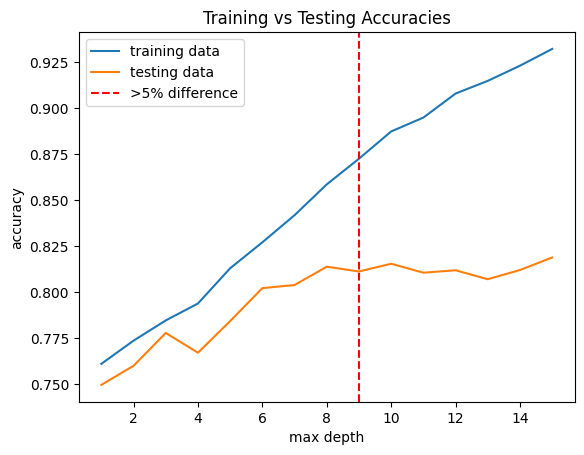

In [61]:
visualize_overfitting(accuracies_dict, "max depth", "accuracy", "Training vs Testing Accuracies")

In [62]:
# Max depth of 8 seems to be a decent choice
get_acc_diff_at_point(accuracies_dict, 8)

array([0.04475])

### Run the model with max-depth = 8

In [63]:
dt = DecisionTreeClassifier(max_depth=8)
metrics, iters = monte_carlo_cv(dt, dfs["lg"]["data"], dfs["lg"]["labels"], n_iterations=500)

Progress: iteration 0
Progress: iteration 10
Progress: iteration 20
Progress: iteration 30
Progress: iteration 40
Progress: iteration 50
Progress: iteration 60
Progress: iteration 70
Progress: iteration 80
Progress: iteration 90
Progress: iteration 100
Progress: iteration 110
Progress: iteration 120
Progress: iteration 130
Progress: iteration 140
Progress: iteration 150
Progress: iteration 160
Progress: iteration 170
Progress: iteration 180
Progress: iteration 190
Progress: iteration 200
Progress: iteration 210
Progress: iteration 220
Progress: iteration 230
Progress: iteration 240
Progress: iteration 250
Progress: iteration 260
Progress: iteration 270
Progress: iteration 280
Progress: iteration 290
Progress: iteration 300
Progress: iteration 310
Progress: iteration 320
Progress: iteration 330
Progress: iteration 340
Progress: iteration 350
Progress: iteration 360
Progress: iteration 370
Progress: iteration 380
Progress: iteration 390
Progress: iteration 400
Progress: iteration 410
Pro

(np.float64(0.804), np.float64(0.021))

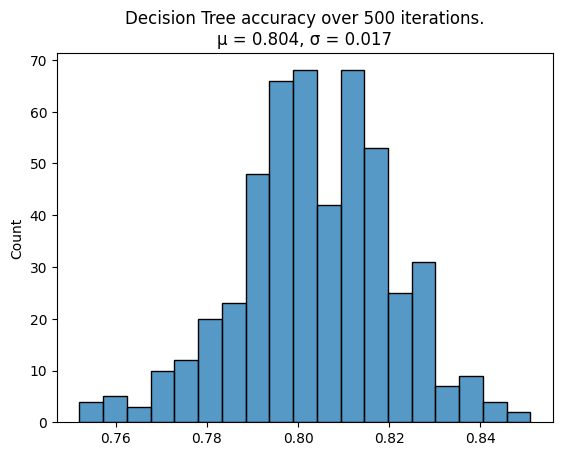

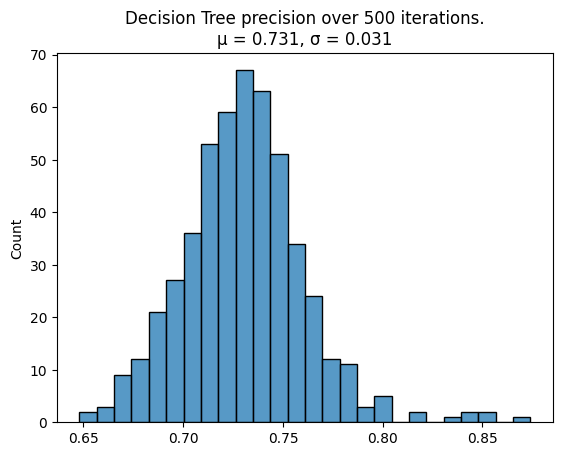

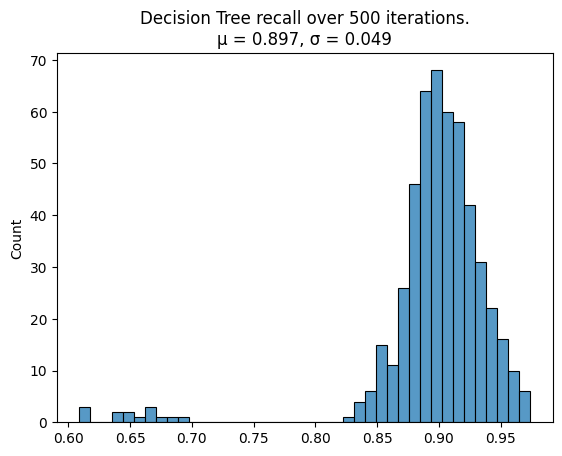

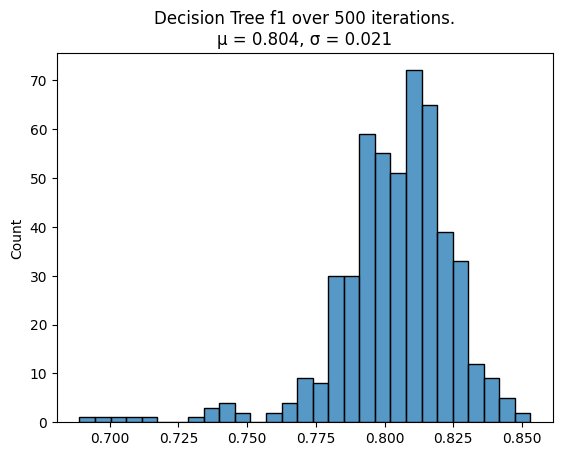

In [65]:
dt_dict = {
    "model": dt,
    "metrics": metrics
}

models = update(models, "Decision Tree", dt_dict)
plot_metric_histograms("Decision Tree", metrics, iters)

In [105]:
manual_metrics = create_manual_metrics(manual_metrics, "Decision Tree", 0.804, 0.731, 0.897, 0.804)

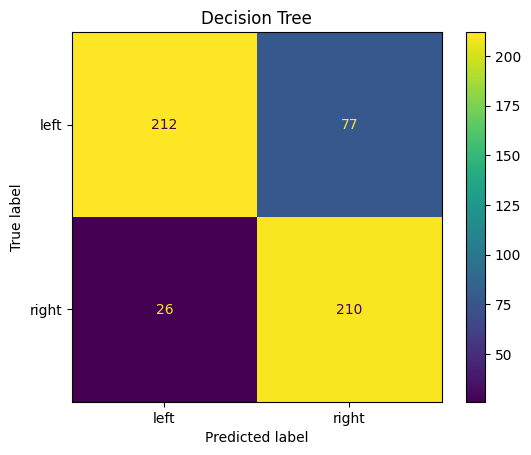

In [231]:
y_true, y_pred = get_middle_y_arrays(metrics)
create_confusion_matrix(y_true, y_pred, "left", "right", "Decision Tree")

In [85]:
dt = DecisionTreeClassifier(max_depth=8)
_, _ = monte_carlo_cv(dt, dfs["lg"]["data"].drop("matters", axis=1), dfs["lg"]["labels"], n_iterations=1)

decision_tree_viz(dt, dfs["lg"]["data"].drop("matters", axis=1).columns, "dt2.jpg")

Progress: iteration 0


In [87]:
dt = DecisionTreeClassifier(max_depth=8)
_, _ = monte_carlo_cv(dt, dfs["lg"]["data"].drop(["matters", "letter"], axis=1), dfs["lg"]["labels"], n_iterations=1)

decision_tree_viz(dt, dfs["lg"]["data"].drop(["matters", "letter"], axis=1).columns, "dt3.jpg")

Progress: iteration 0


# SVM

## What are the best hyper parameter values
##### Hyperparameters to tune
C, degree, gamma

##### Kernels to try
Linear, RBF, Poly

In [92]:
# Set up
c_values = np.array([0.1, 1, 10, 100])
gamma_values = np.array([0.1, 1, 10, 100])
degrees = np.array([2, 3, 4, 5])

In [103]:
# Linear Kernel (gamma and degrees do not matter)
svms_lin = {}

for c in c_values:
    print(f"C={c}")
    key = f"lin-c{c}"
    svms_lin[key] = {}
    svms_lin[key]["model"] = SVC(kernel='linear', C=c)
    metrics, iters = monte_carlo_cv(svms_lin[key]["model"], 
                                    dfs["lg"]["data"], 
                                    dfs["lg"]["labels"], 
                                    n_iterations=2)
    svms_lin[key]["metrics"] = metrics

C=0.1
C=1.0
C=10.0
C=100.0


In [104]:
# RBF Kernel (degrees do not matter)
svms_rbf = {}

for c in c_values:
    for g in gamma_values:
        print(f"C={c}, gamma={g}")
        key = f"lin-c{c}-gamma{g}"
        svms_rbf[key] = {}
        svms_rbf[key]["model"] = SVC(kernel='rbf', C=c, gamma=g)
        metrics, iters = monte_carlo_cv(svms_rbf[key]["model"], 
                                        dfs["lg"]["data"], 
                                        dfs["lg"]["labels"], 
                                        n_iterations=2)
        svms_rbf[key]["metrics"] = metrics

C=0.1, gamma=0.1
C=0.1, gamma=1.0
C=0.1, gamma=10.0


/home/daniel-ethridge/Documents/phd/text-mining/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


C=0.1, gamma=100.0
C=1.0, gamma=0.1
C=1.0, gamma=1.0
C=1.0, gamma=10.0
C=1.0, gamma=100.0
C=10.0, gamma=0.1
C=10.0, gamma=1.0
C=10.0, gamma=10.0
C=10.0, gamma=100.0
C=100.0, gamma=0.1
C=100.0, gamma=1.0
C=100.0, gamma=10.0
C=100.0, gamma=100.0


In [105]:
# Poly Kernel
svms_poly = {}

for c in c_values:
    for g in gamma_values:
        for d in degrees:
            print(f"C={c}, gamma={g}, degree={d}")
            key = f"lin-c{c}-gamma{g}-degree{d}"
            svms_poly[key] = {}
            svms_poly[key]["model"] = SVC(kernel='poly', C=c, gamma=g, degree=d)
            metrics, iters = monte_carlo_cv(svms_poly[key]["model"], 
                                            dfs["lg"]["data"], 
                                            dfs["lg"]["labels"], 
                                            n_iterations=2)
            svms_poly[key]["metrics"] = metrics

C=0.1, gamma=0.1, degree=2
C=0.1, gamma=0.1, degree=3
C=0.1, gamma=0.1, degree=4
C=0.1, gamma=0.1, degree=5
C=0.1, gamma=1.0, degree=2
C=0.1, gamma=1.0, degree=3
C=0.1, gamma=1.0, degree=4
C=0.1, gamma=1.0, degree=5
C=0.1, gamma=10.0, degree=2
C=0.1, gamma=10.0, degree=3
C=0.1, gamma=10.0, degree=4
C=0.1, gamma=10.0, degree=5
C=0.1, gamma=100.0, degree=2
C=0.1, gamma=100.0, degree=3
C=0.1, gamma=100.0, degree=4
C=0.1, gamma=100.0, degree=5
C=1.0, gamma=0.1, degree=2
C=1.0, gamma=0.1, degree=3
C=1.0, gamma=0.1, degree=4
C=1.0, gamma=0.1, degree=5
C=1.0, gamma=1.0, degree=2
C=1.0, gamma=1.0, degree=3
C=1.0, gamma=1.0, degree=4
C=1.0, gamma=1.0, degree=5
C=1.0, gamma=10.0, degree=2
C=1.0, gamma=10.0, degree=3
C=1.0, gamma=10.0, degree=4
C=1.0, gamma=10.0, degree=5
C=1.0, gamma=100.0, degree=2
C=1.0, gamma=100.0, degree=3
C=1.0, gamma=100.0, degree=4
C=1.0, gamma=100.0, degree=5
C=10.0, gamma=0.1, degree=2
C=10.0, gamma=0.1, degree=3
C=10.0, gamma=0.1, degree=4
C=10.0, gamma=0.1, degree=5


In [133]:
# Make a dataframe
lin_columns = svms_lin.keys()
rbf_columns = svms_rbf.keys()
poly_columns = svms_poly.keys()

In [134]:
lin_vals = []
for i, key in enumerate(lin_columns):
    lin_vals.append(svms_lin[key]["metrics"]["testing"]["accuracy"]["mean"])

In [135]:
rbf_vals = []
for i, key in enumerate(rbf_columns):
    rbf_vals.append(svms_rbf[key]["metrics"]["testing"]["accuracy"]["mean"])

In [136]:
poly_vals = []
for i, key in enumerate(poly_columns):
    poly_vals.append(svms_poly[key]["metrics"]["testing"]["accuracy"]["mean"])

In [138]:
all_vals = list(lin_vals) + list(rbf_vals) + list(poly_vals)
all_cols = list(lin_columns) + list(rbf_columns) + list(poly_columns)

In [142]:
df = pd.DataFrame({"models": all_cols, "accuracy": all_vals}).set_index("models")
df.to_csv("svm_accuracies.csv")

In [98]:
# Let's see everything above 0.8
df = pd.read_csv("svm_accuracies.csv")
df.at[20, "models"] = "poly-c0.1-gamma0.1-degree2"
df.at[40, "models"] = "poly-c1.0-gamma1.0-degree2"
df[df["accuracy"] > 0.8]

models  accuracy
0                     lin-c0.1    0.8420
1                     lin-c1.0    0.8105
2                    lin-c10.0    0.8255
3                   lin-c100.0    0.8245
20  poly-c0.1-gamma0.1-degree2    0.8420
40  poly-c1.0-gamma1.0-degree2    0.8050

In [149]:
svm_accuracies_dict = {
    "var": [],
    "training": [],
    "testing": []
}

c_values = np.array([0.1, 1, 10, 100])
for val in c_values:
    print(f"Running with c={val}")
    lin_svm = SVC(kernel="linear", C=val)
    metrics, iters = monte_carlo_cv(lin_svm, 
                                    dfs["lg"]["data"], dfs["lg"]["labels"], 
                                    n_iterations=10, 
                                    check_overfitting=True,
                                    train_size=0.9)

    svm_accuracies_dict["var"].append(val)
    svm_accuracies_dict["training"].append(metrics["training"]["accuracy"]["mean"])
    svm_accuracies_dict["testing"].append(metrics["testing"]["accuracy"]["mean"])
    
for key in accuracies_dict.keys():
    svm_accuracies_dict[key] = np.array(svm_accuracies_dict[key])

Running with c=0.1
Running with c=1.0
Running with c=10.0
Running with c=100.0


(array([0, 1, 2, 3]),)


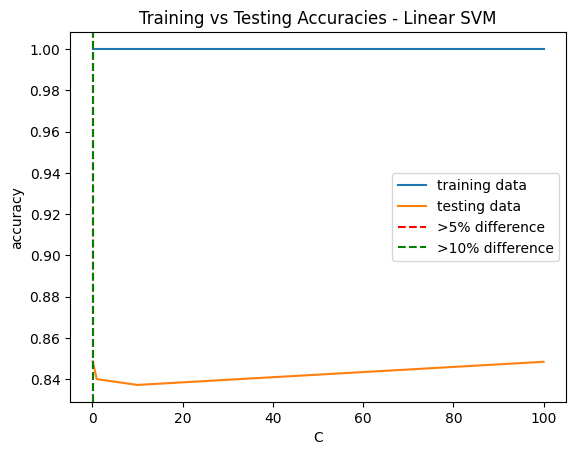

In [150]:
visualize_overfitting(svm_accuracies_dict, "C", "accuracy", "Training vs Testing Accuracies - Linear SVM")

In [153]:
get_acc_diff_at_point(svm_accuracies_dict, 1)

array([0.1599])

In [155]:
svm_p_accuracies_dict = {
    "var": [],
    "training": [],
    "testing": []
}

c_values = np.array([0.1, 1])
for val in c_values:
    print(f"Running with c={val}")
    poly_svm = SVC(kernel="poly", C=val, gamma=val)
    metrics, iters = monte_carlo_cv(poly_svm, 
                                    dfs["lg"]["data"], dfs["lg"]["labels"], 
                                    n_iterations=10, 
                                    check_overfitting=True,
                                    train_size=0.9)

    svm_p_accuracies_dict["var"].append(val)
    svm_p_accuracies_dict["training"].append(metrics["training"]["accuracy"]["mean"])
    svm_p_accuracies_dict["testing"].append(metrics["testing"]["accuracy"]["mean"])
    
for key in accuracies_dict.keys():
    svm_p_accuracies_dict[key] = np.array(svm_p_accuracies_dict[key])

Running with c=0.1
Running with c=1.0


(array([0, 1]),)


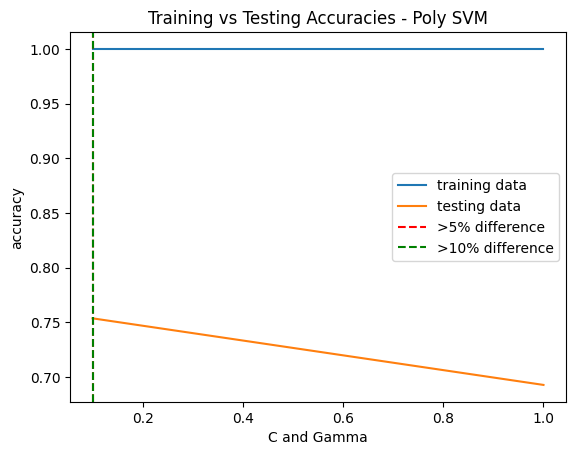

In [156]:
visualize_overfitting(svm_p_accuracies_dict, "C and Gamma", "accuracy", "Training vs Testing Accuracies - Poly SVM")

In [131]:
svm_accuracies_dict = {
    "var": [],
    "training": [],
    "testing": []
}

c_values = np.array([0.0001, 0.001, 0.01])
for val in c_values:
    print(f"Running with c={val}")
    lin_svm = SVC(kernel="linear", C=val)
    metrics, iters = monte_carlo_cv(lin_svm, 
                                    dfs["lg"]["data"], dfs["lg"]["labels"], 
                                    n_iterations=5, 
                                    check_overfitting=True,
                                    train_size=0.9)

    svm_accuracies_dict["var"].append(val)
    svm_accuracies_dict["training"].append(metrics["training"]["accuracy"]["mean"])
    svm_accuracies_dict["testing"].append(metrics["testing"]["accuracy"]["mean"])
    
for key in accuracies_dict.keys():
    svm_accuracies_dict[key] = np.array(svm_accuracies_dict[key])

Running with c=0.0001
Running with c=0.001
Running with c=0.01


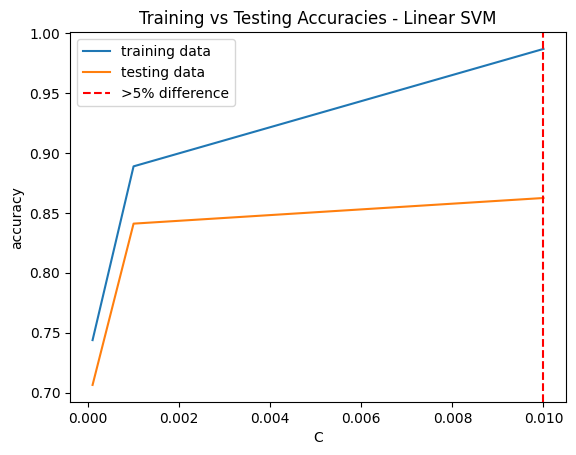

In [132]:
visualize_overfitting(svm_accuracies_dict, "C", "accuracy", "Training vs Testing Accuracies - Linear SVM")

In [138]:
# With the linear SVM, don't go higer than 0.001 on C
get_acc_diff_at_point(svm_accuracies_dict, 0.001)

array([0.0478])

In [208]:
svm_accuracies_dict

{'var': array([0.0001, 0.001 , 0.01  ]),
 'training': array([0.7438, 0.8888, 0.9868]),
 'testing': array([0.7064, 0.841 , 0.8624])}

In [141]:
svm_p_accuracies_dict = {
    "var": [],
    "training": [],
    "testing": []
}

c_values = np.array([0.0001, 0.001, 0.01])
gamma_values = np.array([0.0001, 0.001, 0.01])
for c in c_values:
    for g in gamma_values:
        print(f"Running with c={c}, gamma={g}")
        poly_svm = SVC(kernel="poly", C=c, gamma=g)
        metrics, iters = monte_carlo_cv(poly_svm, 
                                        dfs["lg"]["data"], dfs["lg"]["labels"], 
                                        n_iterations=5, 
                                        check_overfitting=True,
                                        train_size=0.9)

        svm_p_accuracies_dict["var"].append(val)
        svm_p_accuracies_dict["training"].append(metrics["training"]["accuracy"]["mean"])
        svm_p_accuracies_dict["testing"].append(metrics["testing"]["accuracy"]["mean"])
    
for key in accuracies_dict.keys():
    svm_p_accuracies_dict[key] = np.array(svm_p_accuracies_dict[key])

Running with c=0.0001, gamma=0.0001


/home/daniel-ethridge/Documents/phd/text-mining/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/daniel-ethridge/Documents/phd/text-mining/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/daniel-ethridge/Documents/phd/text-mining/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

Running with c=0.0001, gamma=0.001


/home/daniel-ethridge/Documents/phd/text-mining/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/daniel-ethridge/Documents/phd/text-mining/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/daniel-ethridge/Documents/phd/text-mining/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

Running with c=0.0001, gamma=0.01
Running with c=0.001, gamma=0.0001


/home/daniel-ethridge/Documents/phd/text-mining/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/daniel-ethridge/Documents/phd/text-mining/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/daniel-ethridge/Documents/phd/text-mining/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

Running with c=0.001, gamma=0.001


/home/daniel-ethridge/Documents/phd/text-mining/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/daniel-ethridge/Documents/phd/text-mining/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/daniel-ethridge/Documents/phd/text-mining/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

Running with c=0.001, gamma=0.01
Running with c=0.01, gamma=0.0001


/home/daniel-ethridge/Documents/phd/text-mining/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/daniel-ethridge/Documents/phd/text-mining/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/daniel-ethridge/Documents/phd/text-mining/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

Running with c=0.01, gamma=0.001


/home/daniel-ethridge/Documents/phd/text-mining/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/daniel-ethridge/Documents/phd/text-mining/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/daniel-ethridge/Documents/phd/text-mining/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

Running with c=0.01, gamma=0.01


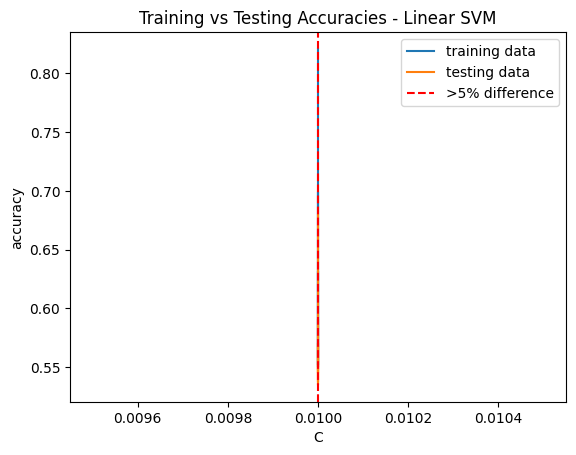

In [143]:
visualize_overfitting(svm_p_accuracies_dict, "C", "accuracy", "Training vs Testing Accuracies - Linear SVM")

In [146]:
svm_p_accuracies_dict["varc"] = np.array([0.0001, 0.0001, 0.0001, 0.001, 0.001, 0.001, 0.01, 0.01, 0.01])
svm_p_accuracies_dict["varg"] = np.array([0.0001, 0.001, 0.01, 0.0001, 0.001, 0.01, 0.0001, 0.001, 0.01])
svm_p_accuracies_dict

{'var': array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]),
 'training': array([0.5484, 0.5506, 0.632 , 0.5514, 0.5514, 0.6988, 0.5518, 0.5498,
        0.8208]),
 'testing': array([0.5668, 0.545 , 0.5704, 0.537 , 0.537 , 0.591 , 0.5348, 0.5622,
        0.6798]),
 'varc': array([0.0001, 0.0001, 0.0001, 0.001 , 0.001 , 0.001 , 0.01  , 0.01  ,
        0.01  ]),
 'varg': array([0.0001, 0.001 , 0.01  , 0.0001, 0.001 , 0.01  , 0.0001, 0.001 ,
        0.01  ])}

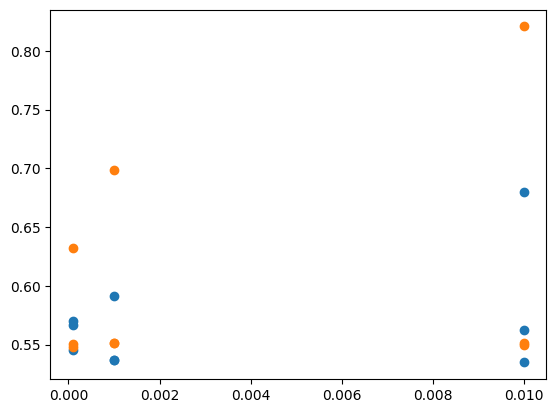

In [151]:
plt.scatter(svm_p_accuracies_dict["varc"], svm_p_accuracies_dict["testing"])
plt.scatter(svm_p_accuracies_dict["varc"], svm_p_accuracies_dict["training"])

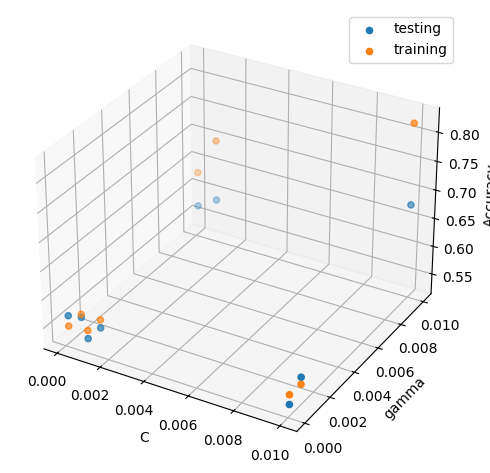

In [160]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.scatter(svm_p_accuracies_dict["varc"], svm_p_accuracies_dict["varg"], svm_p_accuracies_dict["testing"], label="testing")
ax.scatter(svm_p_accuracies_dict["varc"], svm_p_accuracies_dict["varg"], svm_p_accuracies_dict["training"], label="training")
ax.set_xlabel("C")
ax.set_ylabel("gamma")
ax.set_zlabel("Accuracy")
plt.tight_layout()
plt.legend()

In [158]:
svm_testing = svm_p_accuracies_dict["testing"].copy()
svm_training = svm_p_accuracies_dict["training"].copy()

In [184]:
svm_p_accuracies_dict["varc"] = np.array([0.0001, 0.0001, 0.0001, 0.001, 0.001, 0.001, 0.01, 0.01, 0.01])
svm_p_accuracies_dict["varg"] = np.array([0.0001, 0.001, 0.01, 0.0001, 0.001, 0.01, 0.0001, 0.001, 0.01])

In [206]:
idx = 4
print("Training Acc:", np.round(svm_training[idx], 3))
print("Testing Acc:", np.round(svm_testing[idx], 3))
print("Acc Diff:", np.round(svm_training[idx] - svm_testing[idx], 3))

Training Acc: 0.551
Testing Acc: 0.537
Acc Diff: 0.014


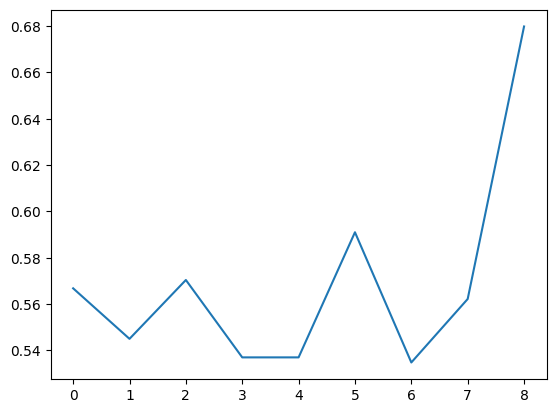

In [172]:
plt.plot(np.arange(0, 9), svm_testing)

# Train the SVMs

In [21]:
# Linear
svm_lin = SVC(kernel="linear", C=0.001)
metrics, iters = monte_carlo_cv(svm_lin, dfs["lg"]["data"], dfs["lg"]["labels"], n_iterations=100)

Progress: iteration 0
Progress: iteration 10
Progress: iteration 20
Progress: iteration 30
Progress: iteration 40
Progress: iteration 50
Progress: iteration 60
Progress: iteration 70
Progress: iteration 80
Progress: iteration 90


(np.float64(0.83), np.float64(0.018))

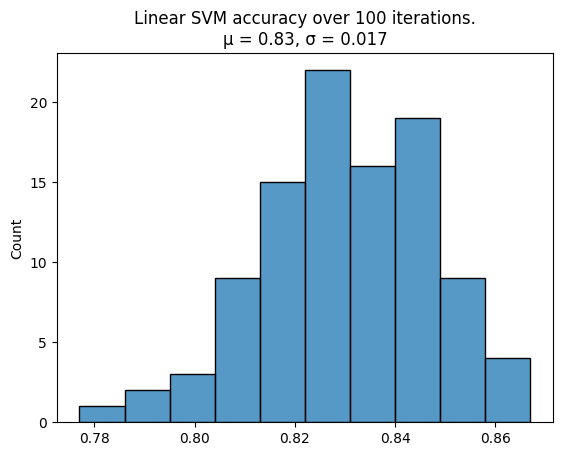

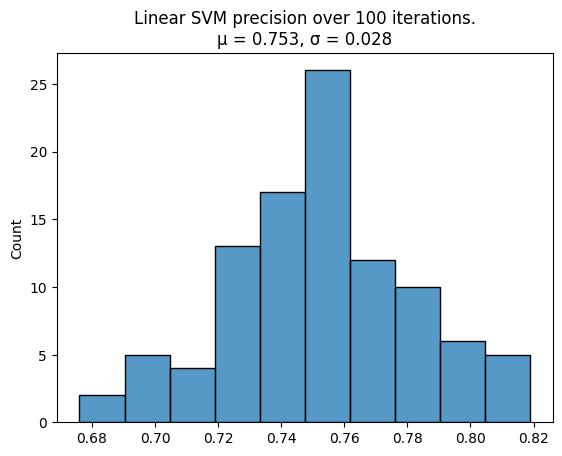

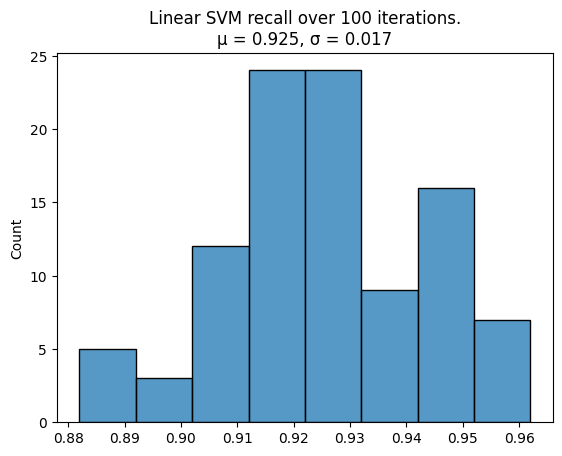

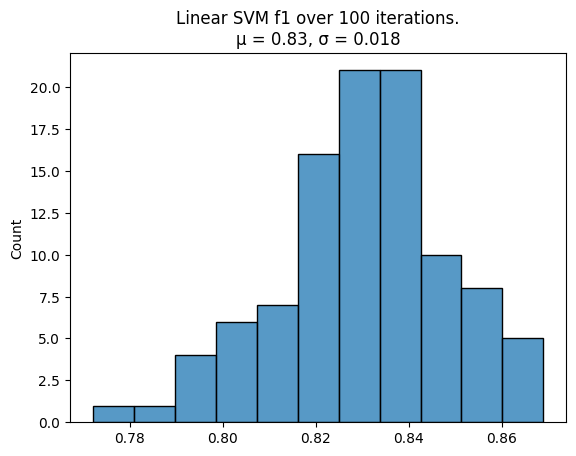

In [22]:
svm_dict = {
    "model": svm_lin,
    "metrics": metrics
}

models = update(models, "SVM - LINEAR", svm_dict)
plot_metric_histograms("Linear SVM", metrics, iters)

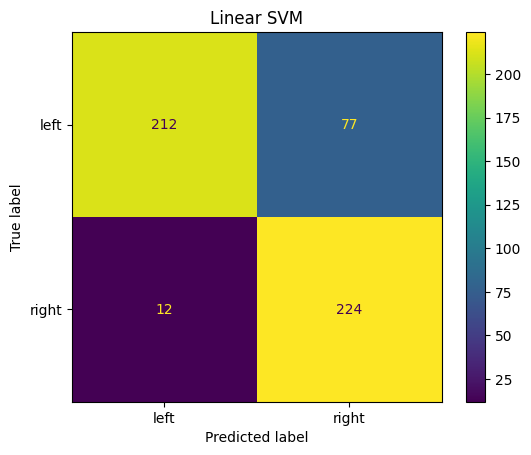

In [23]:
y_true, y_pred = get_middle_y_arrays(metrics)
create_confusion_matrix(y_true, y_pred, "left", "right", "Linear SVM")

In [106]:
manual_metrics = create_manual_metrics(manual_metrics, "SVM Linear", 0.83, 0.753, 0.925, 0.83)

In [33]:
# RBF
svm_rbf = SVC(kernel="rbf", C=0.001, gamma=0.001)
metrics, iters = monte_carlo_cv(svm_rbf, dfs["lg"]["data"], dfs["lg"]["labels"], n_iterations=100)

Progress: iteration 0


/home/daniel-ethridge/Documents/phd/text-mining/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/daniel-ethridge/Documents/phd/text-mining/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/daniel-ethridge/Documents/phd/text-mining/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

Progress: iteration 10


/home/daniel-ethridge/Documents/phd/text-mining/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/daniel-ethridge/Documents/phd/text-mining/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/daniel-ethridge/Documents/phd/text-mining/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

Progress: iteration 20


/home/daniel-ethridge/Documents/phd/text-mining/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/daniel-ethridge/Documents/phd/text-mining/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/daniel-ethridge/Documents/phd/text-mining/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

Progress: iteration 30


/home/daniel-ethridge/Documents/phd/text-mining/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/daniel-ethridge/Documents/phd/text-mining/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/daniel-ethridge/Documents/phd/text-mining/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

Progress: iteration 40


/home/daniel-ethridge/Documents/phd/text-mining/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/daniel-ethridge/Documents/phd/text-mining/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/daniel-ethridge/Documents/phd/text-mining/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

Progress: iteration 50


/home/daniel-ethridge/Documents/phd/text-mining/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/daniel-ethridge/Documents/phd/text-mining/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/daniel-ethridge/Documents/phd/text-mining/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

Progress: iteration 60


/home/daniel-ethridge/Documents/phd/text-mining/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/daniel-ethridge/Documents/phd/text-mining/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/daniel-ethridge/Documents/phd/text-mining/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

Progress: iteration 70


/home/daniel-ethridge/Documents/phd/text-mining/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/daniel-ethridge/Documents/phd/text-mining/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/daniel-ethridge/Documents/phd/text-mining/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

Progress: iteration 80


/home/daniel-ethridge/Documents/phd/text-mining/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/daniel-ethridge/Documents/phd/text-mining/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/daniel-ethridge/Documents/phd/text-mining/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

Progress: iteration 90


/home/daniel-ethridge/Documents/phd/text-mining/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/daniel-ethridge/Documents/phd/text-mining/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/daniel-ethridge/Documents/phd/text-mining/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

(np.float64(0.0), np.float64(0.0))

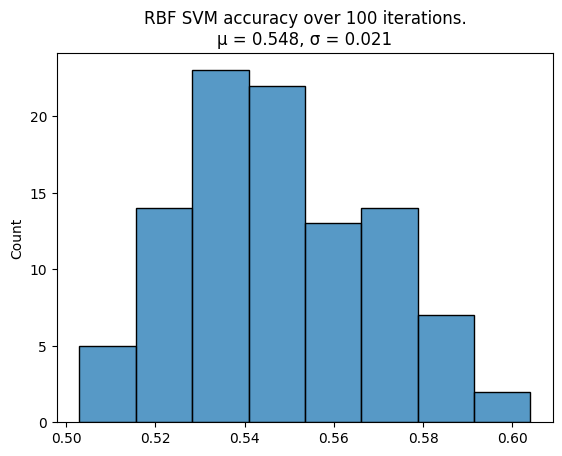

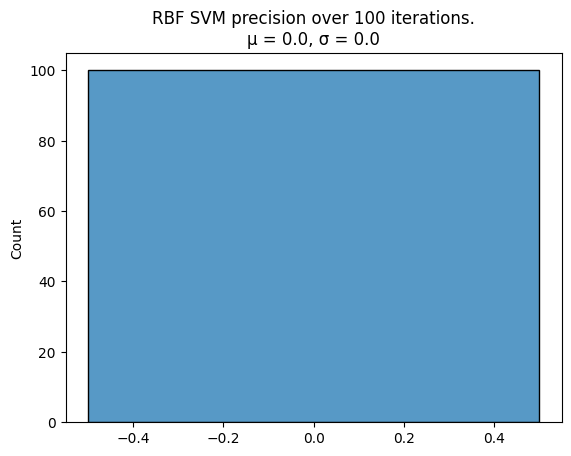

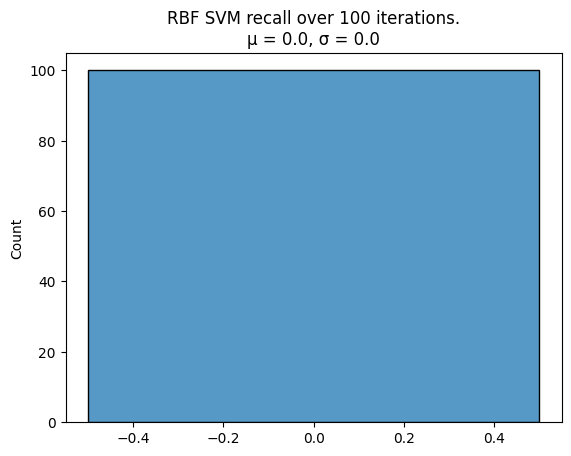

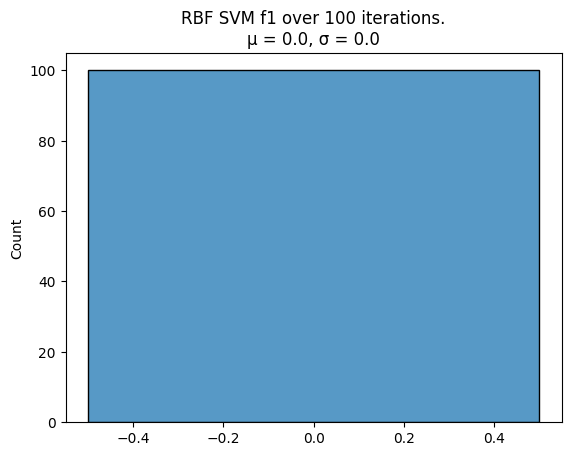

In [34]:
svm_dict = {
    "model": svm_rbf,
    "metrics": metrics
}

models = update(models, "SVM - RBF", svm_dict)
plot_metric_histograms("RBF SVM", metrics, iters)

In [107]:
manual_metrics = create_manual_metrics(manual_metrics, "SVM RBF", 0.548, 0, 0, 0)

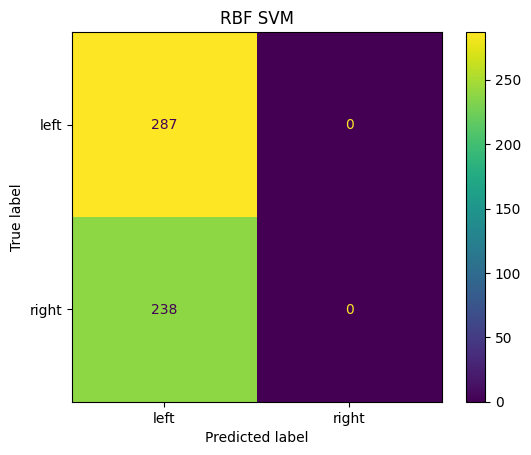

In [35]:
y_true, y_pred = get_middle_y_arrays(metrics)
create_confusion_matrix(y_true, y_pred, "left", "right", "RBF SVM")

In [30]:
# Polynomial
svm_poly = SVC(kernel="poly", C=0.001, gamma=0.001, degree=2)
metrics, iters = monte_carlo_cv(svm_poly, dfs["lg"]["data"], dfs["lg"]["labels"], n_iterations=100)

Progress: iteration 0


/home/daniel-ethridge/Documents/phd/text-mining/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/daniel-ethridge/Documents/phd/text-mining/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/daniel-ethridge/Documents/phd/text-mining/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

Progress: iteration 10


/home/daniel-ethridge/Documents/phd/text-mining/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/daniel-ethridge/Documents/phd/text-mining/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/daniel-ethridge/Documents/phd/text-mining/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

Progress: iteration 20


/home/daniel-ethridge/Documents/phd/text-mining/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/daniel-ethridge/Documents/phd/text-mining/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/daniel-ethridge/Documents/phd/text-mining/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

Progress: iteration 30


/home/daniel-ethridge/Documents/phd/text-mining/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/daniel-ethridge/Documents/phd/text-mining/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/daniel-ethridge/Documents/phd/text-mining/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

Progress: iteration 40


/home/daniel-ethridge/Documents/phd/text-mining/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/daniel-ethridge/Documents/phd/text-mining/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/daniel-ethridge/Documents/phd/text-mining/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

Progress: iteration 50


/home/daniel-ethridge/Documents/phd/text-mining/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/daniel-ethridge/Documents/phd/text-mining/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/daniel-ethridge/Documents/phd/text-mining/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

Progress: iteration 60


/home/daniel-ethridge/Documents/phd/text-mining/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/daniel-ethridge/Documents/phd/text-mining/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/daniel-ethridge/Documents/phd/text-mining/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

Progress: iteration 70


/home/daniel-ethridge/Documents/phd/text-mining/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/daniel-ethridge/Documents/phd/text-mining/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/daniel-ethridge/Documents/phd/text-mining/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

Progress: iteration 80


/home/daniel-ethridge/Documents/phd/text-mining/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/daniel-ethridge/Documents/phd/text-mining/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/daniel-ethridge/Documents/phd/text-mining/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

Progress: iteration 90


/home/daniel-ethridge/Documents/phd/text-mining/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/daniel-ethridge/Documents/phd/text-mining/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/daniel-ethridge/Documents/phd/text-mining/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

(np.float64(0.0), np.float64(0.0))

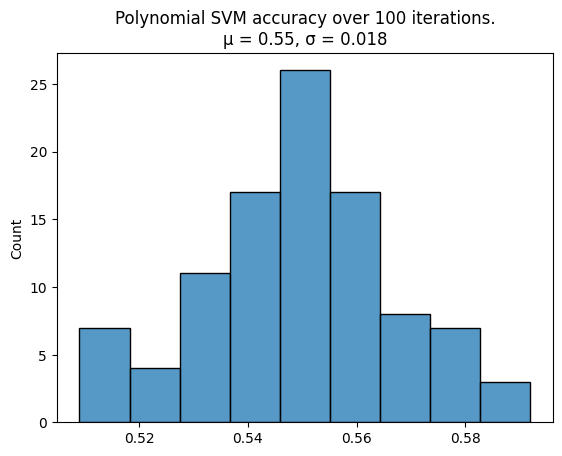

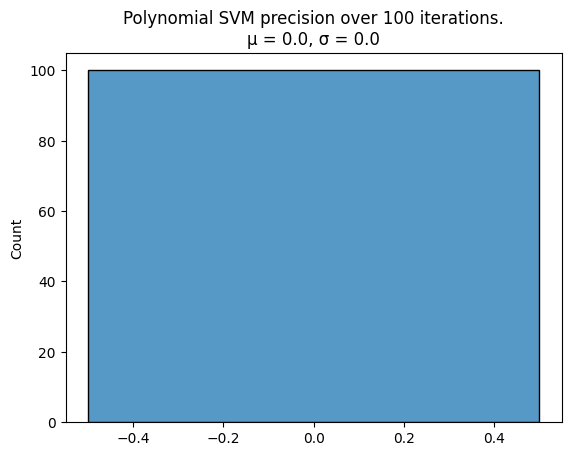

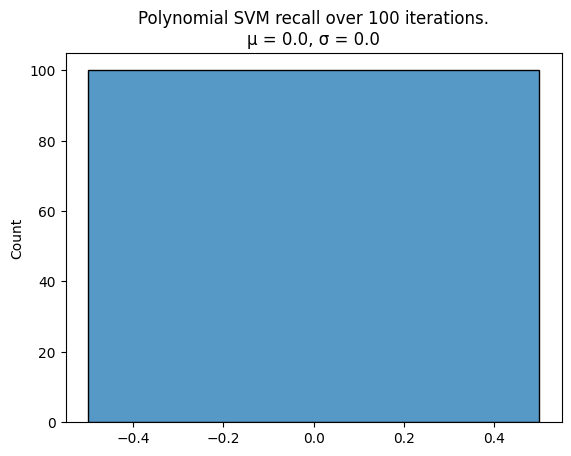

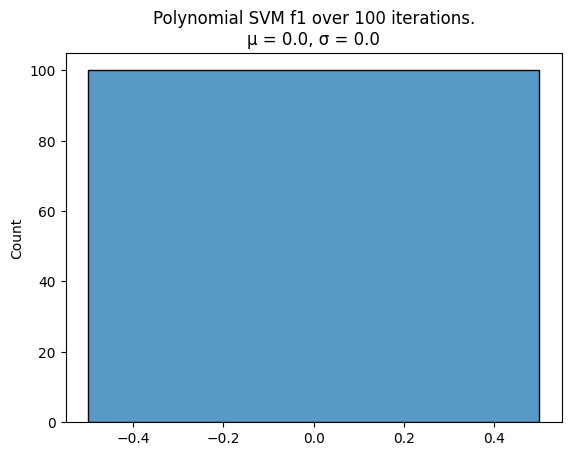

In [31]:
svm_dict = {
    "model": svm_poly,
    "metrics": metrics
}

models = update(models, "SVM - POLY", svm_dict)
plot_metric_histograms("Polynomial SVM", metrics, iters)

In [108]:
manual_metrics = create_manual_metrics(manual_metrics, "SVM Polynomial", 0.55, 0, 0, 0)

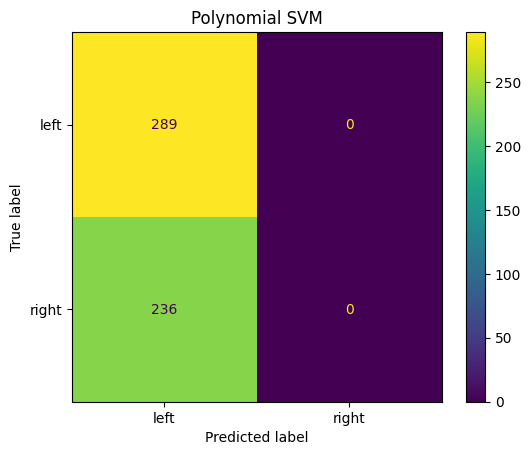

In [32]:
y_true, y_pred = get_middle_y_arrays(metrics)
create_confusion_matrix(y_true, y_pred, "left", "right", "Polynomial SVM")

{'Multinomial NB': {'model': None, 'metrics': None},
 'Decision Tree': {'model': DecisionTreeClassifier(max_depth=8),
  'metrics': {'y_true': [array([1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0,
           1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1,
           0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1,
           1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1,
           0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0,
           1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
           1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1,
           0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1,
           0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0,
           1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1,
           0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0,
           0, 

In [109]:
pd.DataFrame(manual_metrics)

Multinomial NB  Decision Tree  SVM Linear  SVM RBF  SVM Polynomial
accuracy            0.789          0.804       0.830    0.548            0.55
precision           0.735          0.731       0.753    0.000            0.00
recall              0.831          0.897       0.925    0.000            0.00
f1                  0.780          0.804       0.830    0.000            0.00

In [86]:
# Linear
svm_lin_2 = SVC(kernel="linear", C=0.001)
metrics, iters = monte_carlo_cv(svm_lin_2, dfs["lg"]["data"], dfs["lg"]["labels"], n_iterations=1)

Progress: iteration 0


In [115]:
coefs = np.abs(svm_lin_2.coef_[0])
sorted_coefs = coefs.argsort()[::-1]
dfs["lg"]["data"].columns[sorted_coefs][:20]

Index(['matters', 'fight', 'letter', 'photo', 'stay', 'cops', 'months', 'gun',
       'francis', 'including', 'allegedly', 'pm', 'birmingham', 'trump',
       'associated', 'th', 'south', 'shootings', 'texas', 'read'],
      dtype='object')

In [89]:
dfs["lg"]["data"].shape

(2625, 4854)